
Goal
- visualize text statistics w.r.t. data subsets obtaind from pruning

In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


In [2]:
import os
import sys
import numpy as np
import time
import re
from functools import partial

from collections import defaultdict
import glob

import matplotlib.pyplot as plt

import pickle
import pandas as pd
from tqdm import tqdm 

import pyarrow
import torch
import transformers
from transformers import AutoTokenizer

from datasets import load_dataset

In [3]:
from note_pruning_analysis import (
    assets_dir,
    data_inds_dir,
    processed_dir,
    lm_output_dir,
    get_dataset,
    get_dataset_token_lengths,
    get_lm_output,
    get_sorted_inds,
    get_prune_results,
    compute_correlations,
)

### verify if there is correlation between output scores with output token length

In [5]:

# model_name = 'llama-7b'; model_name_or_path='../results/baselines/huggyllama/llama-7b'
model_name = 'llama-7b+lora:r=256:a=256'; model_name_or_path='../results/baselines/huggyllama/llama-7b'

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

Using pad_token, but it is not set yet.


In [6]:
subsample_size = 2000


# get a list of dataset names.
dataset_list = [os.path.basename(x).split('.')[0] 
 for x in glob.glob(os.path.join(lm_output_dir, model_name, '*.pkl'))]
dataset_list = [x for x in dataset_list if 'flan2022' not in x]


lm_outputs = {}
token_lengths = {}
for dataset in dataset_list:
    lm_outputs[dataset] = get_lm_output(dataset, model_name)
    if subsample_size:
        np.random.seed(0)
        inds = np.random.randint(0, list(lm_outputs[dataset].values())[0].shape[0], subsample_size)
    for k, v in lm_outputs[dataset].items():
        lm_outputs[dataset][k] = v[inds]
    token_lengths[dataset] = get_dataset_token_lengths(
        dataset, model_name_or_path, tokenizer, inds=inds if subsample_size else None)


[2023-10-09 14:57:19,735] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-2c6b12c2f11c0937/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-2c6b12c2f11c0937/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-eb938f2a6da5e5da_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-c30f84a2dc784550_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ffcb06a83b4338ce/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ffcb06a83b4338ce/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-a5113a0d5a91ea53_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-db45fcd570bec348/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-db45fcd570bec348/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-3da14401ed1f756e_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-053c40899badb561/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-053c40899badb561/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-56e3fe188fc9e223_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

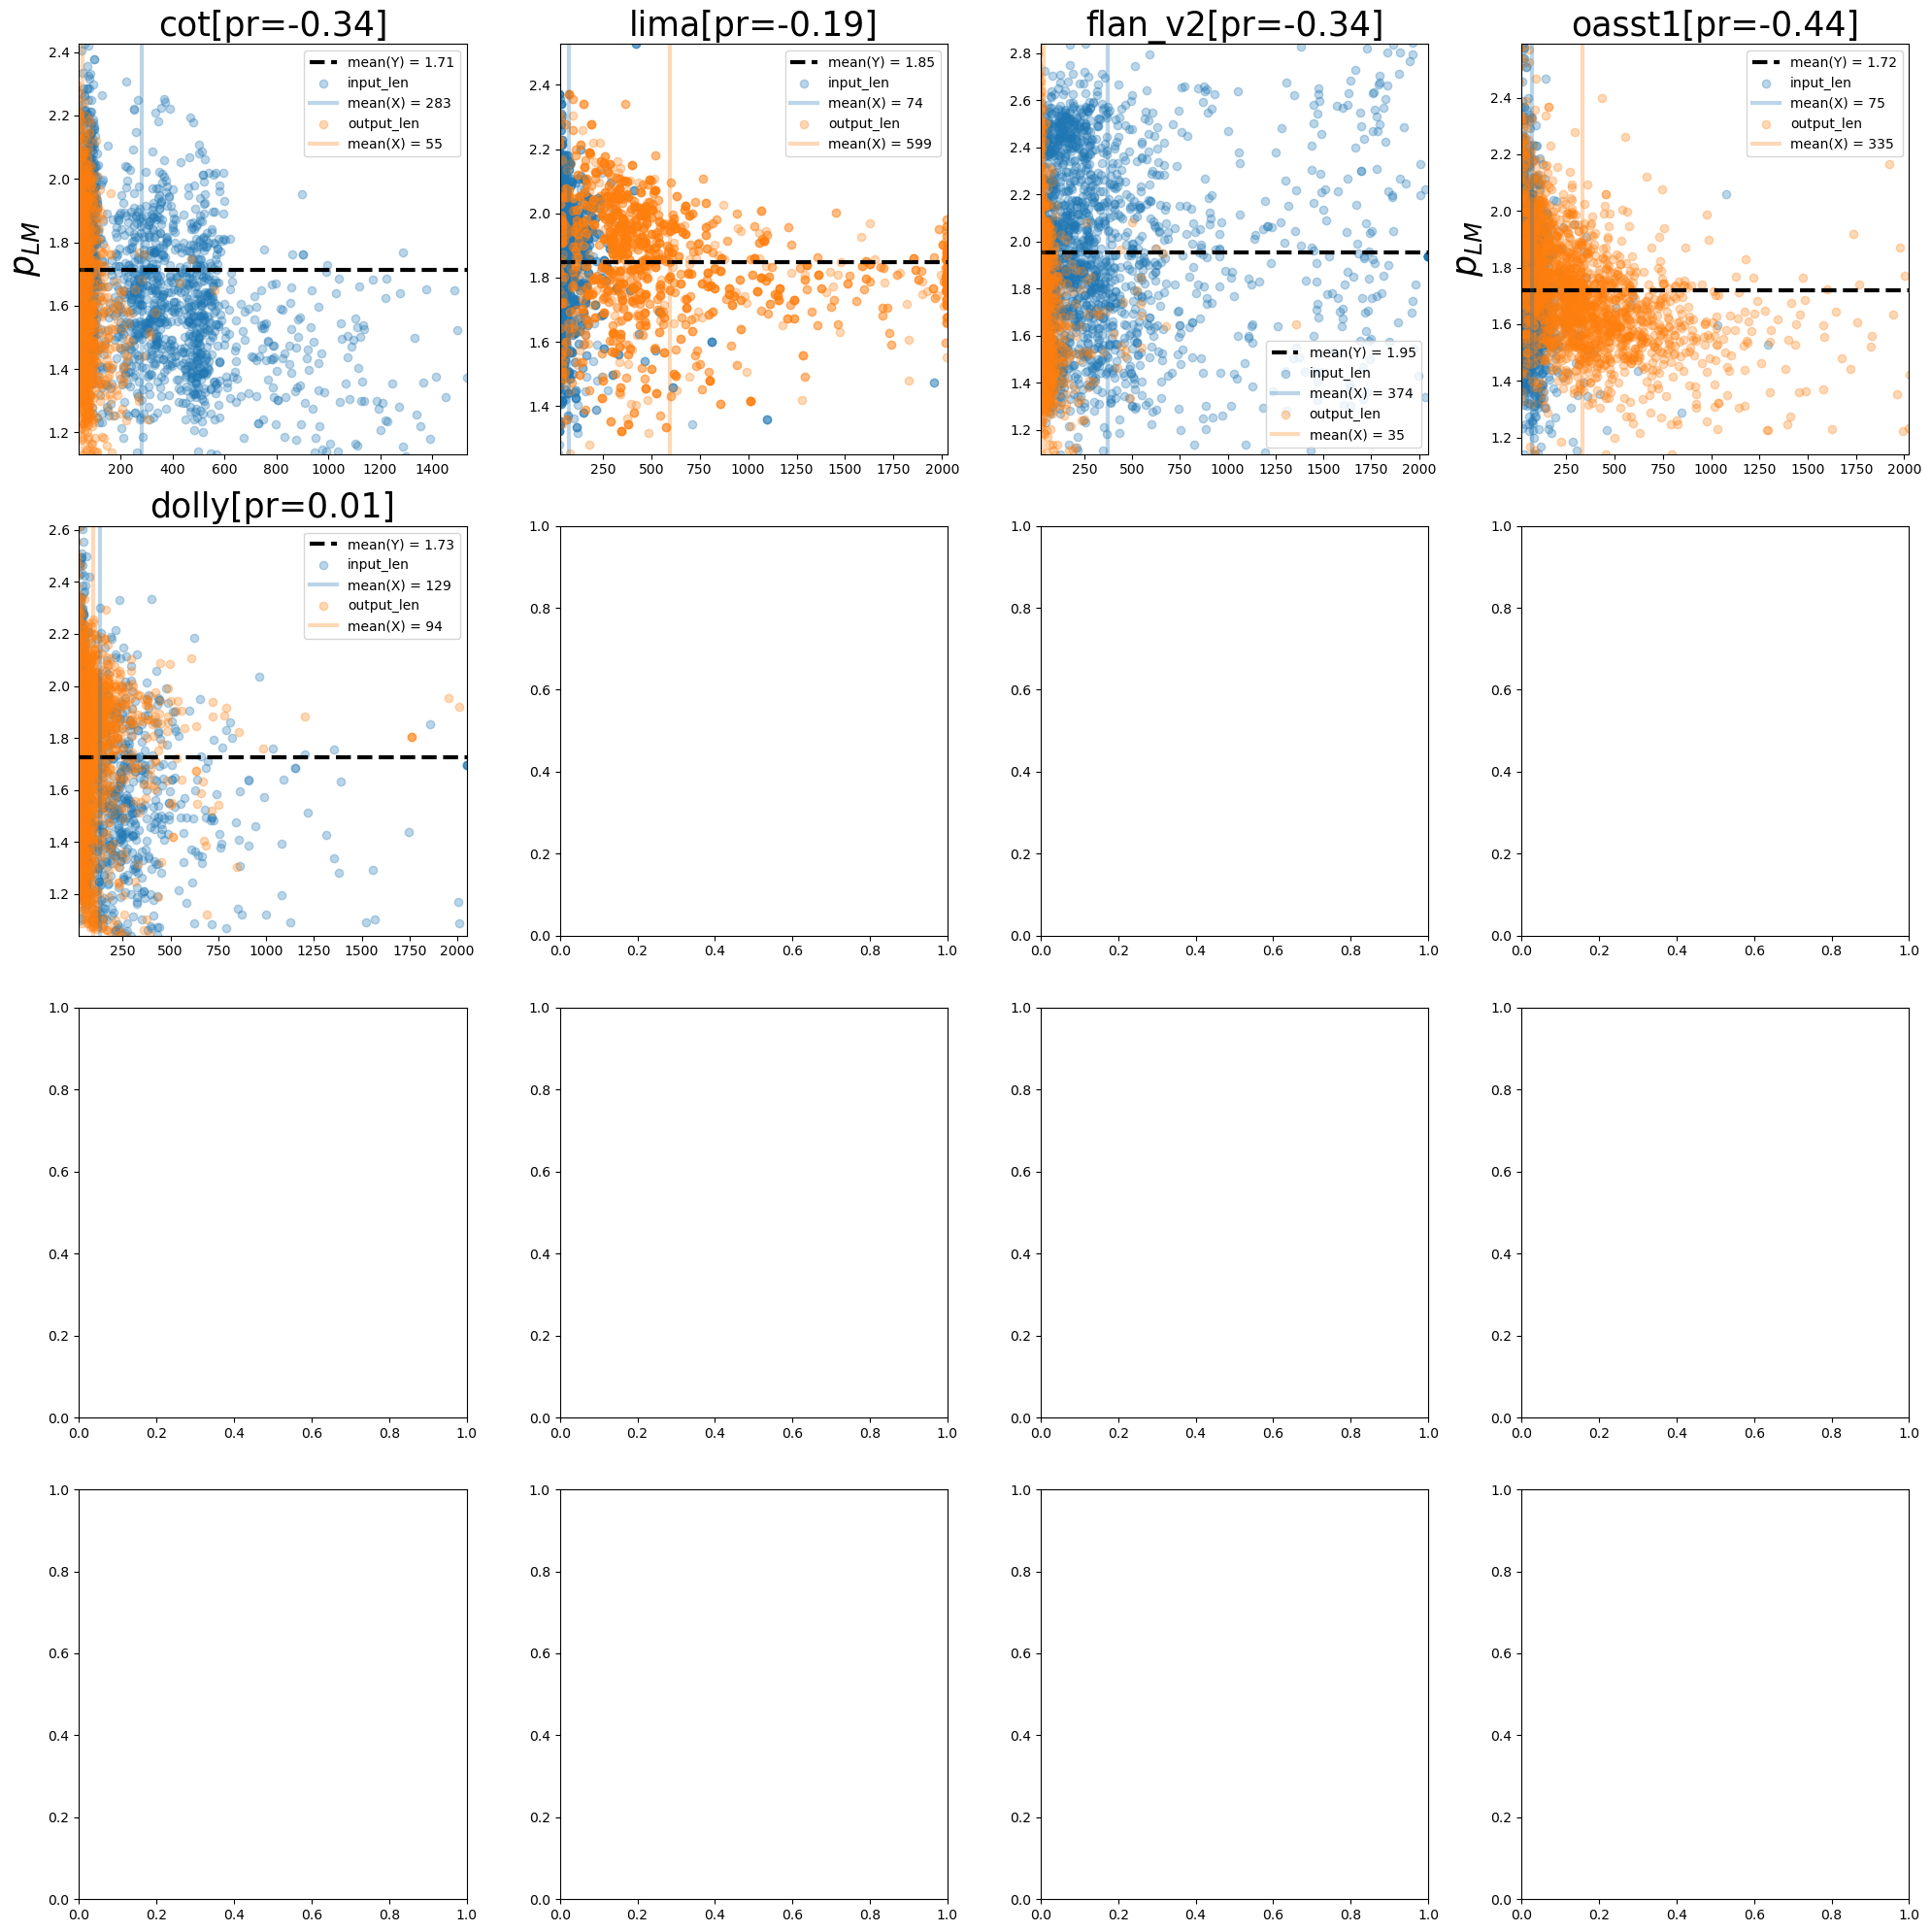

In [16]:

y_label = 'log_prob'
y_label = 'el2n_agg=mean'

w = 5
fig, axs = plt.subplots(4,4, figsize=(w*4,w*4))

for axi, dataset in enumerate(dataset_list):
    
    ## get the information
    logP = lm_outputs[dataset][y_label]
    ys = np.exp(logP)
    input_len = token_lengths[dataset]['input_len']
    output_len = token_lengths[dataset]['output_len']
    
    ## plot the information 
    ax = axs.flatten()[axi]

    
    mean_y = ys.mean()
    ax.axhline(y=mean_y, color='k', linestyle='--', linewidth=3, label=f'mean(Y) = {mean_y:.2f}')

    for label, xs in [
            ('input_len', input_len),
            ('output_len', output_len),
        ]:
        scatter = ax.scatter(xs, ys, label=label, alpha=.3)
        mean_x = xs.mean()
        ax.axvline(x=mean_x, color=scatter.get_facecolor()[0], linestyle='-', linewidth=3, label=f'mean(X) = {mean_x:.0f}')


    ax.legend()
    eps = .001

    ax.set_ylim(np.quantile(ys, eps), np.quantile(ys, 1-eps))
    xs_for_xlim = np.maximum(input_len, output_len)
    ax.set_xlim(np.quantile(xs_for_xlim, eps), np.quantile(xs_for_xlim, 1-eps))
    
    # ax.set_xlabel('token lengths', fontsize=20)
    if axi%3 == 0:
        ax.set_ylabel('$p_{LM}$', fontsize=25)
        
        
    corr = compute_correlations(xs, ys, 'pearsonr')
    ax.set_title(f'{dataset}[pr={corr:.2f}]', fontsize=25)

    
    
fig.tight_layout()
save_path = os.path.join(assets_dir, 'note_pruning_analysis_prob_vs_tokenlen.png')
# fig.savefig(save_path, bbox_inches='tight', dpi=100)

### analyze difference/similarity between sorted indices with different `sort_by`. see if they correlate with each other, e.g., first k item overlap.


In [4]:
pkl_files = glob.glob(os.path.join(data_inds_dir, '**/**/*.pkl'))
pkl_files = [get_prune_results(x) for x in pkl_files]

dfo = pd.DataFrame(pkl_files)
dfo

,model_name,dataset,sort_by,pkl_path,inds,S,kmeans
0,pythia-1b-deduped,cot,kmeansl2_nc=3000_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[33040, 20796, 20778, 53475, 20753, 53467, 692...","[14.19522641596984, 9.780138445664921, 16.8840...",NaN
1,pythia-1b-deduped,cot,grad_last_l2n_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[35469, 41233, 46411, 75629, 69637, 59780, 767...","[23.100366592407227, 4.731935501098633, 11.848...",NaN
2,pythia-1b-deduped,cot,el2n_agg=mean_decr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[16291, 90361, 45738, 22332, 31730, 34875, 688...","[0.81982421875, 0.246826171875, 0.4482421875, ...",NaN
3,pythia-1b-deduped,cot,logit_margin_decr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[46411, 83671, 69637, 75629, 73593, 91155, 597...","[-2.025390625, 4.4609375, 1.1318359375, -0.892...",NaN
4,pythia-1b-deduped,cot,log_prob_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[55989, 14529, 45738, 35321, 24767, 85538, 927...","[-3.52734375, -0.85498046875, -1.9169921875, -...",NaN
...,...,...,...,...,...,...,...
280,pythia-1b-deduped+lora:r=256:a=256,oasst1,el2n_agg=mean_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[11073, 17484, 18002, 16639, 18234, 18235, 128...","[0.69580078125, 0.595703125, 0.716796875, 0.68...",NaN
281,pythia-1b-deduped+lora:r=256:a=256,oasst1,el2n_agg=l2n_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[19045, 12312, 12398, 414, 22862, 14992, 24158...","[13.03125, 14.71875, 11.5390625, 10.40625, 24....",NaN
282,pythia-1b-deduped+lora:r=256:a=256,oasst1,kmeansl2_nc=3000_decr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[26267, 26269, 26268, 22468, 8481, 17485, 2432...","[10.099533841222962, 0.0, 21.42898308798626, 2...",NaN
283,pythia-1b-deduped+lora:r=256:a=256,oasst1,grad_loraB_l2n_decr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[27083, 6806, 26200, 22853, 14279, 18559, 2970...","[1.6941574811935425, 1.3808244466781616, 1.892...",NaN


In [22]:
from note_pruning_analysis import get_dataset
sort_by_categories = None

model_name = 'llama-7b' # 'llama-7b+lora:r=256:a=256'

dataset = 'flan2022_1m'
dataset = 'tulu_v1_mix'
sort_by_categories = [
    'log_prob_incr', 'logit_margin_incr', 'el2n_agg=l2n_incr', 'el2n_agg=mean_incr', 'grad_loraB_l2n_incr', 
#     'kmeansl2_emb=grad+rp+loraB_nc=3000_incr', 'kmeansl2_emb=text+embedding_nc=3000_incr', 
    'kmeansl2_emb=text+embedding_nc=300_incr', 'kmeansl2_emb=text+embedding_nc=1000_incr', 'kmeansl2_emb=text+embedding_nc=3000_incr', 'kmeansl2_emb=text+embedding_nc=6000_incr', 
    'kmeansl2_emb=grad+rp+loraB_nc=300_incr', 'kmeansl2_emb=grad+rp+loraB_nc=1000_incr', 'kmeansl2_emb=grad+rp+loraB_nc=3000_incr', 'kmeansl2_emb=grad+rp+loraB_nc=6000_incr', 
#     'kmeanscd_nc=3000_incr', 'kmeansl2_nc=3000_incr', 'kmeansl2_nc=6000_incr',
]

# dataset = 'lima' # llama-7b/lima contains full grad norm! compare it with lora grad norm
# sort_by_categories = [
#     'log_prob_incr', 'logit_margin_incr', 'el2n_agg=l2n_incr', 'el2n_agg=mean_incr', 
#     'grad_last_l2n_incr', 'grad_mlp_l2n_incr', 'grad_qkv_l2n_incr', 'grad_loraB_l2n_incr', 'grad_all_l2n_incr',
#     'kmeansl2_emb=grad+rp+loraB_nc=30_incr', 'kmeansl2_emb=text+embedding_nc=30_incr',
# ]

# model_name = 'pythia-1b-deduped'
# # model_name = 'pythia-1b-deduped+lora:r=256:a=256'
# # dataset = 'lima'
# # dataset = 'flan_v2'
# sort_by_categories = ['log_prob_incr', 'logit_margin_incr', 'el2n_agg=l2n_incr', 'el2n_agg=mean_incr', 
#                       'grad_last_l2n_incr', 'grad_mlp_l2n_incr', 'grad_qkv_l2n_incr', 'grad_loraB_l2n_incr', 'grad_all_l2n_incr',
#                       'kmeanscd_nc=3000_incr', 'kmeansl2_nc=3000_incr', 
#                      ]


ds = get_dataset(dataset, processed=False if 'flan2022' in dataset else True)
ds_len = len(ds)

filter_fn = lambda x: \
    x['model_name'].startswith(model_name) and \
    x['dataset'] == dataset


df = dfo.copy()
df = df[df.apply(filter_fn, axis=1)]
df = df.sort_values('sort_by')
df = df[df['sort_by'].apply(lambda x: 'decr' not in x)] # just increasing score.
df = df[~df['S'].isnull()]
df = df[~df['sort_by'].apply(lambda x: any(y==x for y in ['el2n_incr', 'prob_incr']))]
print(df['sort_by'].tolist())
if sort_by_categories:
    print(f"Not shown: {set(df['sort_by'].to_list()) - set(sort_by_categories)}")
    df['sort_by'] = pd.Categorical(df['sort_by'], categories=sort_by_categories, ordered=True)
    df = df.sort_values(by='sort_by')
    df = df[pd.notnull(df['sort_by'])]
# compare full grad norm with lora grad norm
df = df[df.apply(lambda r: 'lora' in r['model_name'] or ('lora' not in r['model_name'] and 'grad' in r['sort_by']), 1)]
if dataset.startswith('flan2022'):
    ds_task = ds['task']
    df['tasks'] = df['inds'].apply(lambda inds: [ds_task[i] for i in inds.tolist()])
else:
    ds_task = [x.split('_')[0] for x in ds['id']]
    df['tasks'] = df['inds'].apply(lambda inds: [ds_task[i] for i in inds.tolist()])
df = df.reset_index(drop=True)

df

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/json/default-3458257ec7c242fc/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


['el2n_agg=mean_incr', 'grad_loraB_l2n_incr', 'kmeansl2_emb=grad+rp+loraB_nc=1000_incr', 'kmeansl2_emb=grad+rp+loraB_nc=3000_incr', 'kmeansl2_emb=grad+rp+loraB_nc=300_incr', 'kmeansl2_emb=text+embedding_nc=1000_incr', 'kmeansl2_emb=text+embedding_nc=3000_incr', 'kmeansl2_emb=text+embedding_nc=300_incr', 'log_prob_incr', 'logit_margin_incr']
Not shown: set()


,model_name,dataset,sort_by,pkl_path,inds,S,kmeans,tasks
0,llama-7b+lora:r=256:a=256,tulu_v1_mix,log_prob_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[77530, 294486, 265346, 41431, 50341, 379007, ...","[-4.2871479988098145, -1.0222018957138062, -2....",NaN,"[flan, gpt4, gpt4, flan, flan, sharegpt, oasst..."
1,llama-7b+lora:r=256:a=256,tulu_v1_mix,logit_margin_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[77530, 294486, 50341, 379007, 41431, 54677, 2...","[-2.577099561691284, 3.25048828125, -0.4544270...",NaN,"[flan, gpt4, flan, sharegpt, flan, flan, gpt4,..."
2,llama-7b+lora:r=256:a=256,tulu_v1_mix,el2n_agg=mean_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[213905, 316147, 400309, 208108, 310398, 32578...","[0.9012805819511414, 0.32581090927124023, 0.59...",NaN,"[dolly, code, sharegpt, dolly, code, sharegpt,..."
3,llama-7b+lora:r=256:a=256,tulu_v1_mix,grad_loraB_l2n_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[82310, 240017, 91395, 346535, 12179, 240018, ...","[8.706167221069336, 3.0460360050201416, 14.564...",NaN,"[flan, oasst1, flan, sharegpt, flan, oasst1, f..."
4,llama-7b+lora:r=256:a=256,tulu_v1_mix,kmeansl2_emb=text+embedding_nc=300_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[96802, 182699, 25302, 189181, 246086, 246087,...","[22.714529042772988, 26.757889267797133, 27.35...","MiniBatchKMeans(batch_size=512, max_no_improve...","[flan, cot, flan, cot, oasst1, oasst1, sharegp..."
5,llama-7b+lora:r=256:a=256,tulu_v1_mix,kmeansl2_emb=text+embedding_nc=1000_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[311583, 98271, 294247, 216541, 97642, 42945, ...","[20.949403621296955, 25.17072993376717, 15.543...","MiniBatchKMeans(batch_size=512, max_no_improve...","[code, flan, gpt4, oasst1, flan, flan, dolly, ..."
6,llama-7b+lora:r=256:a=256,tulu_v1_mix,kmeansl2_emb=text+embedding_nc=3000_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[467888, 192306, 243897, 174813, 205117, 21399...","[23.285327429139915, 24.05785598753377, 16.289...","MiniBatchKMeans(batch_size=512, max_no_improve...","[sharegpt, cot, oasst1, cot, dolly, dolly, cot..."
7,llama-7b+lora:r=256:a=256,tulu_v1_mix,kmeansl2_emb=grad+rp+loraB_nc=300_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[233082, 339262, 233520, 182492, 181737, 39721...","[8.190040826718528, 2.7910322299698485, 12.540...","MiniBatchKMeans(batch_size=512, max_no_improve...","[oasst1, sharegpt, oasst1, cot, cot, sharegpt,..."
8,llama-7b+lora:r=256:a=256,tulu_v1_mix,kmeansl2_emb=grad+rp+loraB_nc=1000_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[436165, 426133, 461360, 461359, 406544, 45533...","[8.132935532712105, 2.7164567320578605, 11.557...","MiniBatchKMeans(batch_size=512, max_no_improve...","[sharegpt, sharegpt, sharegpt, sharegpt, share..."
9,llama-7b+lora:r=256:a=256,tulu_v1_mix,kmeansl2_emb=grad+rp+loraB_nc=3000_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[241072, 119195, 119141, 295609, 295740, 29598...","[8.151499905759655, 2.603047773470426, 9.28441...","MiniBatchKMeans(batch_size=512, max_no_improve...","[oasst1, cot, cot, gpt4, gpt4, gpt4, sharegpt,..."


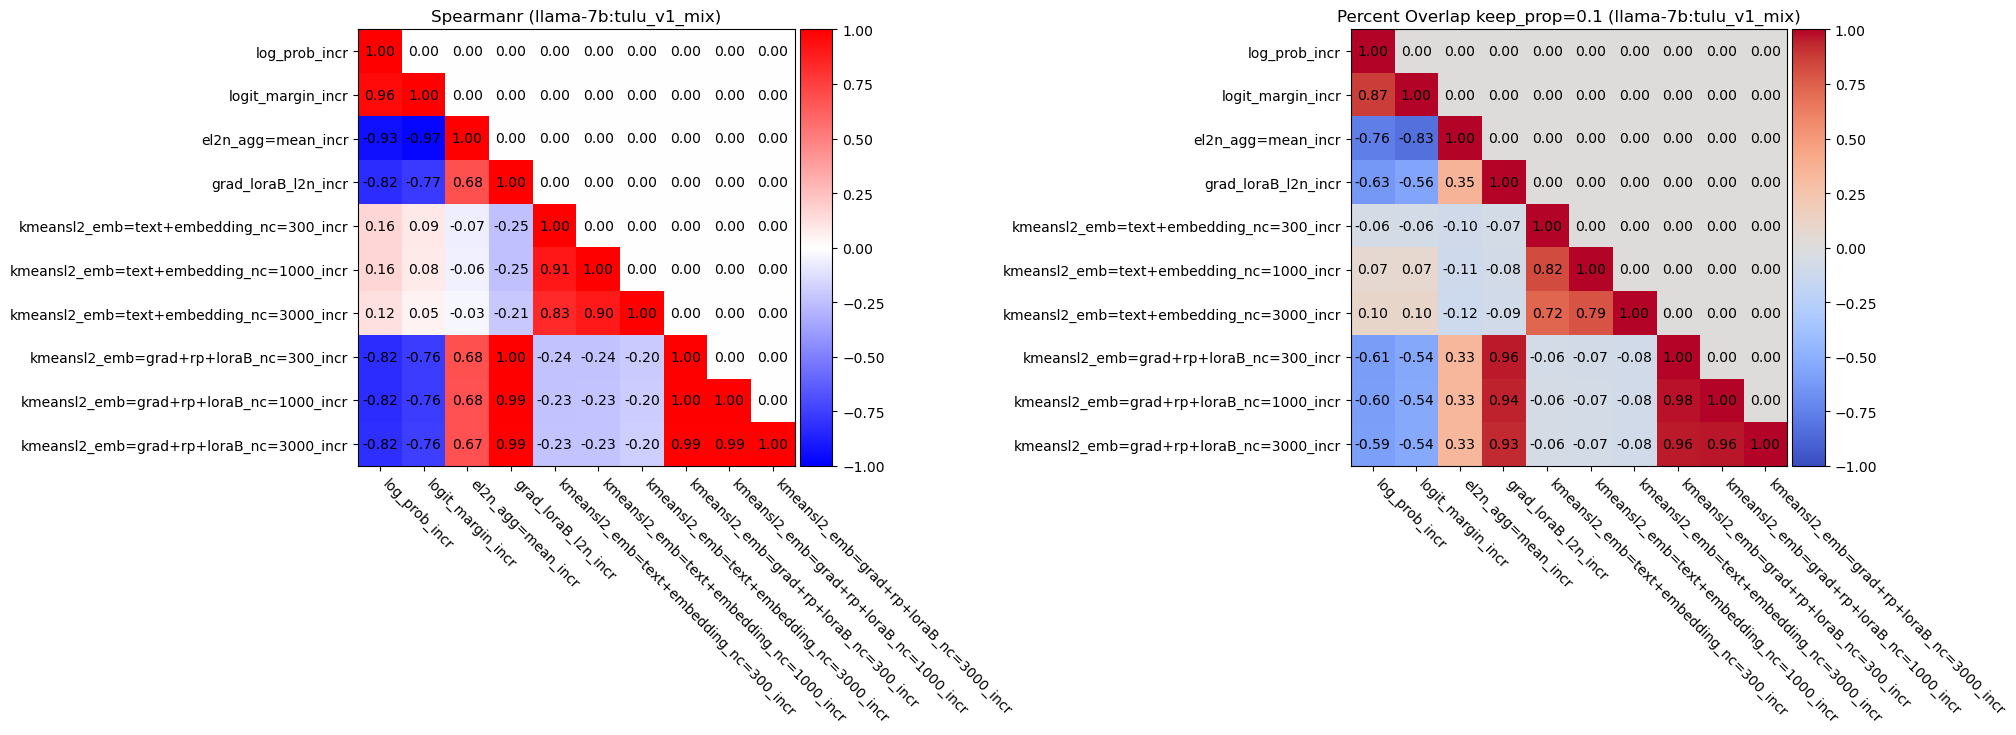

In [16]:
from rosemary import plt_kernel_matrix_one
import matplotlib.pyplot as plt
from scipy import stats

sort_by_list = df['sort_by'].tolist()
inds_list = df['inds'].tolist()
scores_list = df['S'].tolist()

keep_prop = .1
M = int(keep_prop*ds_len)
N = len(scores_list)
rank_corr = np.zeros((N, N))
overlap = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        scores_i = scores_list[i]
        scores_j = scores_list[j]
        inds_i = inds_list[i]
        inds_j = inds_list[j]
        if j < i:
            rank_corr[i,j] = stats.spearmanr(scores_i, scores_j).statistic
            positive_overlap = len(np.intersect1d(inds_i[:M], inds_j[:M]))/M
            negative_overlap = -(
                len(np.intersect1d(inds_i[-M:], inds_j[:M]))/M + 
                len(np.intersect1d(inds_i[:M], inds_j[-M:]))/M
            )/2
            overlap[i,j] = positive_overlap if positive_overlap+negative_overlap>0 else negative_overlap
        if i == j:
            rank_corr[i, j] = 1
            overlap[i, j] = 1
        

fig, axs = plt.subplots(1, 2, figsize=(20,10))
ax = axs[0]
plt_kernel_matrix_one(
    fig, ax, rank_corr, title=f'Spearmanr ({model_name}:{dataset})', 
    vmin=-1, vmax=1, cmap='bwr', n_ticks=N, annotate=True)
ax.set_xticklabels(sort_by_list, rotation=-45, ha='left')
ax.set_yticklabels(sort_by_list)

ax = axs[1]
plt_kernel_matrix_one(
    fig, ax, overlap, title=f'Percent Overlap keep_prop={keep_prop:.1f} ({model_name}:{dataset})', 
    vmin=-1, vmax=1, cmap='coolwarm', n_ticks=N, annotate=True)
ax.set_xticklabels(sort_by_list, rotation=-45, ha='left')
ax.set_yticklabels(sort_by_list)
fig.tight_layout()

save_plt = 1
if save_plt:
    save_path = os.path.join(
        assets_dir, f'note_pruning_analysis_rank_corr_{model_name}:{dataset}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)

### Get an idea proportion of sub-datasets on pruned dataset.

In [91]:
tasks = df.set_index("sort_by")["tasks"].to_dict()
M = 200000 # flan2022
filter_fn = lambda k: True

M = 50000 # tuluv1m. ~10% of data
filter_fn = lambda k: ('nc=1000' in k) if k.startswith('kmeansl2') else True

tasks_for_sort_by_decr = {}
for k, v in tasks.items():
    if 'incr' in k and filter_fn(k):
        tasks_for_sort_by_decr[k.split('incr')[0]+'decr'] = v[::-1]
tasks = {k: v for k, v in tasks.items() if filter_fn(k)}
tasks.update(tasks_for_sort_by_decr)
tasks = dict(sorted(tasks.items(), key=lambda x: x[0]))

In [94]:
from collections import Counter

def compute_task_props(x):
    counts = dict(Counter(x[:M]))
    counts = {k: counts[k]/M for k in sorted(counts.keys())}
    return counts

sort_by_counts = {k: compute_task_props(v) for k, v in tasks.items()}
sort_by_counts

{'el2n_agg=mean_decr': {'code': 0.01642,
  'cot': 0.14788,
  'dolly': 0.0218,
  'flan': 0.7085,
  'gpt4': 0.05266,
  'oasst1': 0.03412,
  'sharegpt': 0.01862},
 'el2n_agg=mean_incr': {'code': 0.10962,
  'cot': 0.1568,
  'dolly': 0.0329,
  'flan': 0.0565,
  'gpt4': 0.02574,
  'oasst1': 0.02092,
  'sharegpt': 0.59752},
 'grad_loraB_l2n_decr': {'code': 0.01898,
  'cot': 0.00312,
  'dolly': 0.01828,
  'flan': 0.90158,
  'gpt4': 0.03814,
  'oasst1': 0.01012,
  'sharegpt': 0.00978},
 'grad_loraB_l2n_incr': {'code': 0.00104,
  'cot': 0.00028,
  'dolly': 0.00254,
  'flan': 0.01012,
  'gpt4': 0.00126,
  'oasst1': 0.00854,
  'sharegpt': 0.97622},
 'kmeansl2_emb=grad+rp+loraB_nc=1000_decr': {'code': 0.0212,
  'cot': 0.00622,
  'dolly': 0.02026,
  'flan': 0.88366,
  'gpt4': 0.04446,
  'oasst1': 0.01424,
  'sharegpt': 0.00996},
 'kmeansl2_emb=grad+rp+loraB_nc=1000_incr': {'code': 0.00092,
  'cot': 0.00114,
  'dolly': 0.00248,
  'flan': 0.01128,
  'gpt4': 0.00156,
  'oasst1': 0.00864,
  'sharegpt': 

baseline_props:  {'flan': 0.21, 'cot': 0.21, 'dolly': 0.03, 'oasst1': 0.07, 'gpt4': 0.11, 'code': 0.04, 'sharegpt': 0.33}


/tmp/ipykernel_1401080/1161876597.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(counts.keys()), rotation=-45, ha='left')


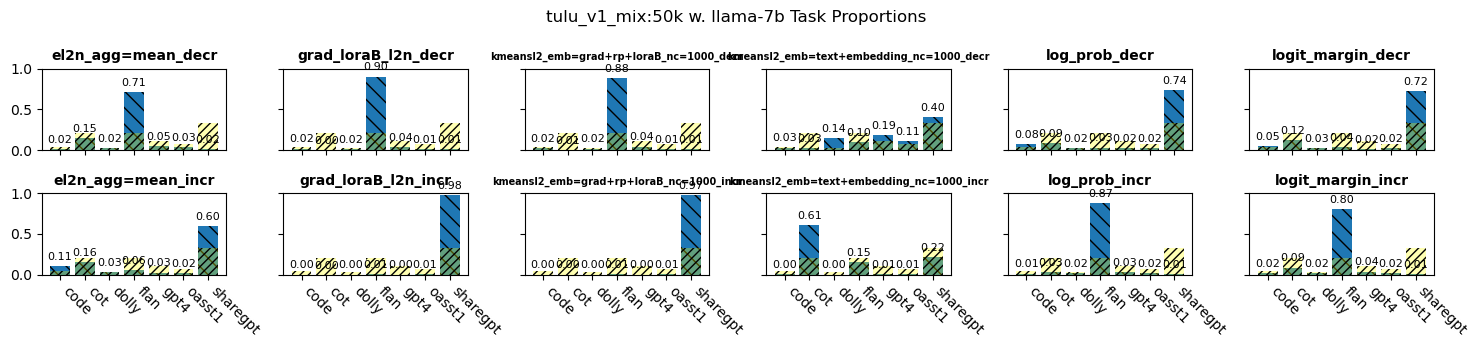

In [95]:
from rosemary import plt_barplot_add_labels


if dataset == 'flan2022':
    baseline_props = {'flan': .4, 't0': .32, 'niv2': .2, 'cot': .05, 'dialog': .03}
else:
    d = dict(Counter(ds_task))
    baseline_props = {k: v/np.sum(list(d.values())) for k, v in d.items()}
print('baseline_props: ', {k: np.round(v, 2) for k,v in baseline_props.items()})
N = len(tasks)//2
# fig, axs = plt.subplots(N, 2, figsize=(5, N*1.5), sharey=True) # height=1.5, width=2.5
fig, axs = plt.subplots(2, N, figsize=(N*2.5, 3.5), sharey=True, sharex=True)
# N = len(tasks)//4
# fig, axs = plt.subplots(4, N, figsize=(N*2.5, 7), sharey=True, sharex=True)

for i, (k, counts) in enumerate(sort_by_counts.items()):
    ax = np.ravel(axs, order='F')[i] # C/F
    bars = ax.bar(counts.keys(), counts.values(), label=k, hatch='\\\\')
    plt_barplot_add_labels(ax, bars, fontsize=8) # , fontsize=7
    ax.bar(counts.keys(), list([baseline_props[k] for k in counts.keys()]), 
           alpha=0.3, hatch='////', color='yellow', label='original')
    if 'kmeansl2_emb' in k:
        fontsize=7
    else:
        fontsize=10
    ax.set_title(k, fontweight='bold', fontsize=fontsize)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(list(counts.keys()), rotation=-45, ha='left')
#     if i==0: break
    
fig.suptitle(f'{dataset}:{M/1000:.0f}k w. {model_name} Task Proportions')
fig.tight_layout()

save_plt = 1
if save_plt:
    save_path = os.path.join(
        assets_dir, f'note_pruning_analysis_task_props_{model_name}:{dataset}:{M/1000:.0f}k.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)

### visualize text statistics w.r.t. data subsets obtaind from pruning, e.g., token length, P_LM, etc.

In [ ]:
from scipy.interpolate import make_interp_spline

smooth_kernel_size = 20
# xs_max = total_data_size # M_min
# xs_max = M_min

ylabel_list = ['$P_{LM}$', 'input_len', 'output_len', 'pruning_score']
# sort_by_list = [
#     'dppmap_k=Kcos', 'dppmap_k=Kcos1np',
#     'dppmap_k=Kcosp', 
#     'prob_decr', 
#     'kmeansl2_nc=3000_decr',
#     'random',
# ]

N = len(ylabel_list)
fig, axs = plt.subplots(2, N ,figsize=(5*N, 5*2))

for i, xs_max in enumerate([M_min, total_data_size]):

    for j, ylabel in enumerate(ylabel_list):
        ax = axs[i, j]

        for sort_by in sort_by_list:
            I = np.array(inds[sort_by]['inds'])
            xs = np.round(np.linspace(0, min(xs_max, len(I))-1, 1000)).astype(np.int32)

            if ylabel == '$P_{LM}$':
                ys = logP[I[xs]].squeeze()
                ys = np.exp(ys)
            elif ylabel == 'input_len':
                ys = input_len[I[xs]]
            elif ylabel == 'output_len':
                ys = output_len[I[xs]]
            elif ylabel == 'pruning_score':
                if 'S' not in inds[sort_by]:
                    continue
                ys = np.array(inds[sort_by]['S']).squeeze()[xs]
            else:
                continue

            line, = ax.plot(xs/total_data_size, ys, alpha=.05)
            color = line.get_color()
            ys_smoothed = np.convolve(ys, np.ones(smooth_kernel_size)/smooth_kernel_size, mode='same')
            ax.plot(xs/total_data_size, ys_smoothed, color=color, label=sort_by)

        ax.legend()
        ax.set_ylabel(ylabel, fontsize=25)
        ax.set_xlabel('% Data Selected', fontsize=25)

        if ylabel in ['input_len', 'output_len']:
            ax.set_ylim((0, 700))

suptitle = f'[{dataset}] Text statistics for data subsets'
fig.suptitle(suptitle, fontsize=30)
fig.tight_layout()

save_path = os.path.join(
    assets_dir, f'note_pruning_analysis_text_statistics_trend_{dataset}.png')
fig.savefig(save_path, bbox_inches='tight', dpi=100)